In [33]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision import datasets
from torch.utils.data import WeightedRandomSampler
from torch import tensor
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy

device = 'cpu' 
if torch.cuda.is_available(): 
 device='cuda'
elif torch.backends.mps.is_available():
 device = 'mps' 

print("device = ", device)
DEVICE = torch.device(device)

# if torch.cuda.is_available():
#     print('CUDA is available. Working on GPU')
#     DEVICE = torch.device('cuda')
# else:
#     print('CUDA is not available. Working on CPU')
#     DEVICE = torch.device('cpu')

device =  cuda


In [2]:
!sudo tljh-config set services.cull.enabled False
!sudo tljh-config reload

active
Hub not ready: (HTTP status 502)
Hub reload with new configuration complete


In [4]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [28]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    
    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)
    
    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")
    
    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")
    
    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)
    return accuracy, f1_score, precision, recall

In [5]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)
    
    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [6]:
os.getcwd()
os.chdir("../../..")
os.getcwd()

'/home/jupyter-jhub-admin'

In [7]:
root_dir=os.getcwd()
ataroot = os.path.join(root_dir, 'data','xview2','all_hurricanes')

In [8]:
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

valid_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [9]:
train_all_dataset = datasets.ImageFolder(os.path.join(ataroot,'train', 'img_mask_ov_crop_class'), transform=train_transform)
valid_all_dataset = datasets.ImageFolder(os.path.join( ataroot, 'hold' ,'img_mask_ov_crop_class'), transform=valid_transform)
test_all_dataset = datasets.ImageFolder(os.path.join( ataroot, 'test' , 'img_mask_ov_crop_class'), transform=test_transform)
print("Train set records : ", len(train_all_dataset))
print("Validation set records : ", len(valid_all_dataset))
print("Test set records : ", len(test_all_dataset))

trainset_all = torch.utils.data.Subset(train_all_dataset, list(range(len(train_all_dataset))))
testset_all = torch.utils.data.Subset(test_all_dataset, list(range(len(test_all_dataset))))
validset_all = torch.utils.data.Subset(valid_all_dataset, list(range(len(valid_all_dataset))))

#sampler = torch.utils.data.sampler.WeightedRandomSampler(element_weights, num_epoch_elements, replacement=False)

batch_size = 128

# prepare data loaders
train_loader_all = DataLoader(train_all_dataset, batch_size=batch_size, num_workers=2)
valid_loader_all = DataLoader(valid_all_dataset, batch_size=batch_size, num_workers=2)
test_loader_all = DataLoader(test_all_dataset, batch_size=batch_size, num_workers= 2)

Train set records :  64454
Validation set records :  22107
Test set records :  19299


In [10]:
num_epochs = 15

In [11]:
class_names = train_all_dataset.classes
print("class_names ",class_names)

class_dict = train_all_dataset.class_to_idx
print("class_dict ",class_dict)

class_names  ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
class_dict  {'destroyed': 0, 'major-damage': 1, 'minor-damage': 2, 'no-damage': 3}


In [12]:
train_all_labels, train_all_labels_count = get_label_stats(train_loader_all)

The number of samples per classes in training dataset:

	 0: 3359
	 1: 13330
	 2: 14550
	 3: 33215


In [13]:
valid_all_labels, valid_all_labels_count = get_label_stats(valid_loader_all)

The number of samples per classes in training dataset:

	 0: 1251
	 1: 4133
	 2: 6192
	 3: 10531


In [14]:
test_labels, test_labels_count = get_label_stats(test_loader_all)

The number of samples per classes in training dataset:

	 0: 1068
	 1: 3500
	 2: 4623
	 3: 10108


In [15]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)
    
    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    return class_weights

In [16]:
class_weights_all=get_class_weights(train_all_labels)
print("Class weights", class_weights_all)

class_weights_all = torch.tensor(class_weights_all, dtype=torch.float32).to('cpu')
# balanced sampler
weights_all = class_weights_all[train_all_labels]
ws_all = WeightedRandomSampler(weights_all, len(weights_all), replacement=True)

Class weights [19.18844894313784, 4.835258814703676, 4.429828178694158, 1.9405088062622307]


In [17]:
train_loader_ws_all = DataLoader(trainset_all, batch_size=batch_size, sampler=ws_all , num_workers=2)

In [18]:
train_labels_ws_all, train_labels_count_ws_all = get_label_stats(train_loader_ws_all)

The number of samples per classes in training dataset:

	 0: 16106
	 1: 16105
	 2: 16237
	 3: 16006


### Densenet 161

/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  7%|▋         | 1/15 [09:35<2:14:23, 575.95s/it]

	| New lowest val loss for DenseNet161: 0.009424234196100844
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [19:12<2:04:53, 576.44s/it]

	| New lowest val loss for DenseNet161: 0.008852556214385642
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [28:49<1:55:19, 576.65s/it]

	| New lowest val loss for DenseNet161: 0.008773546632710082
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [38:25<1:45:40, 576.37s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [48:02<1:36:04, 576.47s/it]

	| New lowest val loss for DenseNet161: 0.008617774056505035
Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [57:37<1:26:25, 576.17s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [1:07:13<1:16:48, 576.04s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [1:16:49<1:07:12, 576.01s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [1:26:26<57:37, 576.26s/it]  

	| New lowest val loss for DenseNet161: 0.008555173016513344
Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [1:36:02<48:00, 576.15s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:45:38<38:24, 576.10s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:55:14<28:48, 576.11s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [2:04:50<19:12, 576.12s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [2:14:26<09:36, 576.18s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [2:24:03<00:00, 576.22s/it]


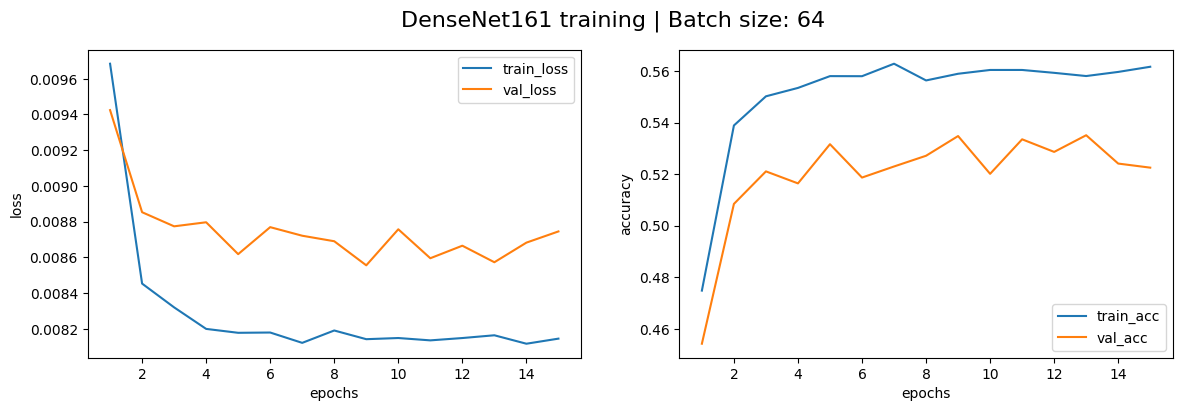


Training results:
	Min val loss 0.0086 was achieved during epoch #9
	Val accuracy during min val loss is 0.5348


In [19]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_loader_ws_all,
                                        val_dataloader=valid_loader_all)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Resnet152

/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/jupyter-jhub-admin/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 187MB/s] 
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [09:17<2:10:02, 557.29s/it]

	| New lowest val loss for ResNet152: 0.009304554065715648
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [18:35<2:00:53, 557.98s/it]

	| New lowest val loss for ResNet152: 0.008707147681923946
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [27:53<1:51:35, 557.95s/it]

	| New lowest val loss for ResNet152: 0.008668751898229044
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [37:11<1:42:15, 557.73s/it]

	| New lowest val loss for ResNet152: 0.008642345910890458
Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [46:27<1:32:50, 557.08s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [55:42<1:23:29, 556.56s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [1:04:57<1:14:09, 556.19s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [1:14:13<1:04:51, 555.99s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [1:23:29<55:35, 555.85s/it]  

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [1:32:44<46:18, 555.65s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:41:59<37:01, 555.38s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:51:13<27:45, 555.20s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [2:00:28<18:30, 555.01s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [2:09:42<09:14, 554.76s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [2:18:56<00:00, 555.76s/it]


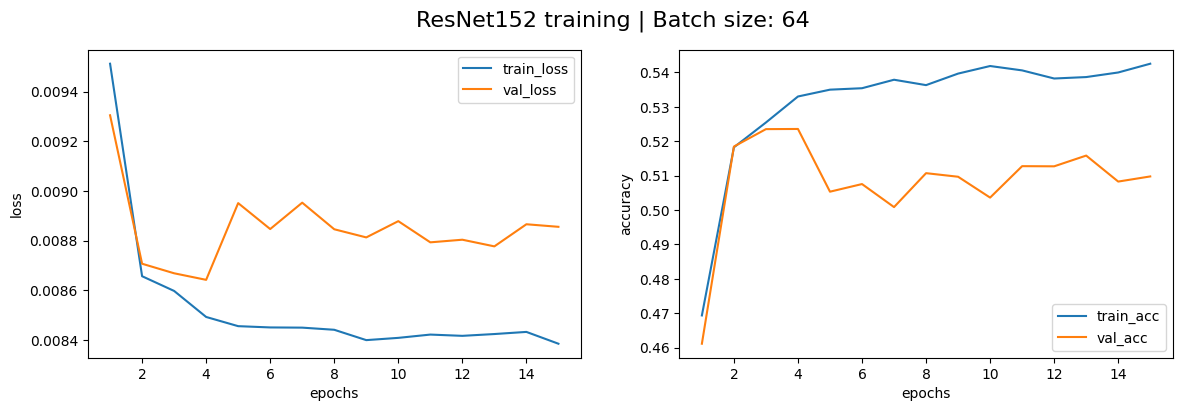


Training results:
	Min val loss 0.0086 was achieved during epoch #4
	Val accuracy during min val loss is 0.5235


In [20]:

model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 200)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_loader_ws_all,
                                      val_dataloader=valid_loader_all)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))


### VGG 19

/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/jupyter-jhub-admin/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 205MB/s] 
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  7%|▋         | 1/15 [08:35<2:00:18, 515.61s/it]

	| New lowest val loss for VGG19_bn: 0.00923870551422762
Epoch: 2 | Learning rate: [0.0003]


 13%|█▎        | 2/15 [17:14<1:52:07, 517.47s/it]

	| New lowest val loss for VGG19_bn: 0.009139680040628425
Epoch: 3 | Learning rate: [0.0003]


 20%|██        | 3/15 [25:52<1:43:35, 517.98s/it]

	| New lowest val loss for VGG19_bn: 0.008847898559772634
Epoch: 4 | Learning rate: [3.267e-05]


 27%|██▋       | 4/15 [34:27<1:34:42, 516.57s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 33%|███▎      | 5/15 [43:01<1:25:57, 515.79s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 40%|████      | 6/15 [51:36<1:17:18, 515.34s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 47%|████▋     | 7/15 [1:00:10<1:08:40, 515.09s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 53%|█████▎    | 8/15 [1:08:45<1:00:04, 514.97s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 60%|██████    | 9/15 [1:17:20<51:29, 514.85s/it]  

Epoch: 10 | Learning rate: [3.557763e-06]


 67%|██████▋   | 10/15 [1:25:54<42:53, 514.75s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 73%|███████▎  | 11/15 [1:34:29<34:18, 514.66s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 80%|████████  | 12/15 [1:43:03<25:43, 514.63s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 87%|████████▋ | 13/15 [1:51:38<17:09, 514.59s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 93%|█████████▎| 14/15 [2:00:12<08:34, 514.57s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


100%|██████████| 15/15 [2:08:47<00:00, 515.16s/it]


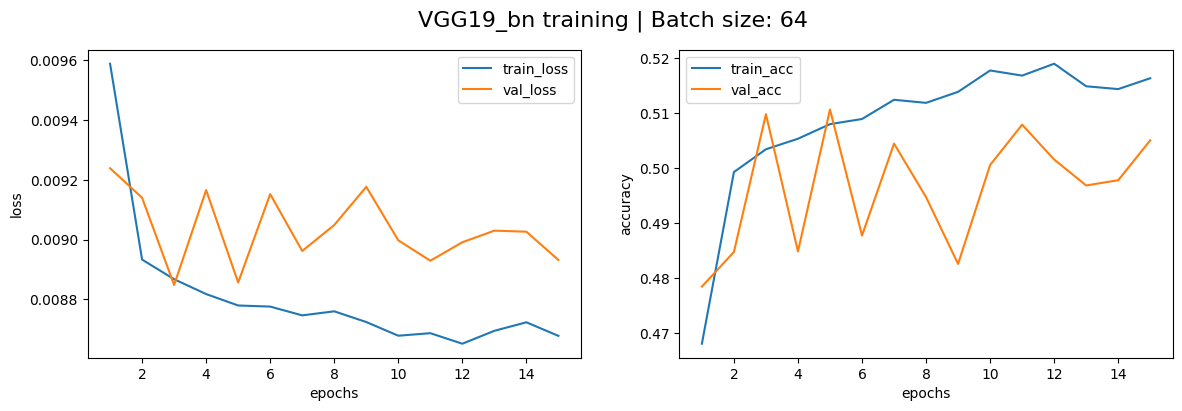


Training results:
	Min val loss 0.0088 was achieved during epoch #3
	Val accuracy during min val loss is 0.5098


In [21]:

model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=200)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_loader_ws_all,
                                     val_dataloader=valid_loader_all)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [22]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(200 * 3, 200)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


/home/jupyter-jhub-admin/.conda/envs/alivio/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  5%|▌         | 1/20 [26:44<8:28:01, 1604.27s/it]

	| New lowest val loss for Ensemble: 0.010471212255661937
Epoch: 2 | Learning rate: [0.0003]


 10%|█         | 2/20 [53:34<8:02:18, 1607.70s/it]

	| New lowest val loss for Ensemble: 0.009862415539380918
Epoch: 3 | Learning rate: [0.0003]


 15%|█▌        | 3/20 [1:20:16<7:34:45, 1605.03s/it]

Epoch: 4 | Learning rate: [3.267e-05]


 20%|██        | 4/20 [1:46:58<7:07:41, 1603.82s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 25%|██▌       | 5/20 [2:13:46<6:41:22, 1605.49s/it]

	| New lowest val loss for Ensemble: 0.009276467380807537
Epoch: 6 | Learning rate: [9.9e-05]


 30%|███       | 6/20 [2:40:26<6:14:12, 1603.74s/it]

Epoch: 7 | Learning rate: [1.0781099999999999e-05]


 35%|███▌      | 7/20 [3:07:14<5:47:46, 1605.08s/it]

	| New lowest val loss for Ensemble: 0.009215147903364905
Epoch: 8 | Learning rate: [3.267e-05]


 40%|████      | 8/20 [3:33:54<5:20:41, 1603.45s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 45%|████▌     | 9/20 [4:00:42<4:54:12, 1604.77s/it]

	| New lowest val loss for Ensemble: 0.009198735543203714
Epoch: 10 | Learning rate: [3.557763e-06]


 50%|█████     | 10/20 [4:27:30<4:27:37, 1605.74s/it]

	| New lowest val loss for Ensemble: 0.009131867457596596
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 55%|█████▌    | 11/20 [4:54:10<4:00:35, 1604.00s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 60%|██████    | 12/20 [5:20:50<3:33:43, 1602.93s/it]

Epoch: 13 | Learning rate: [1.17406179e-06]


 65%|██████▌   | 13/20 [5:47:31<3:06:55, 1602.26s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 70%|███████   | 14/20 [6:14:12<2:40:10, 1601.80s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 75%|███████▌  | 15/20 [6:40:52<2:13:27, 1601.43s/it]

Epoch: 16 | Learning rate: [3.874403907e-07]


 80%|████████  | 16/20 [7:07:34<1:46:45, 1601.37s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 85%|████████▌ | 17/20 [7:34:15<1:20:04, 1601.36s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 90%|█████████ | 18/20 [8:00:56<53:22, 1601.30s/it]  

Epoch: 19 | Learning rate: [1.27855328931e-07]


 95%|█████████▌| 19/20 [8:27:37<26:41, 1601.16s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


100%|██████████| 20/20 [8:54:18<00:00, 1602.92s/it]


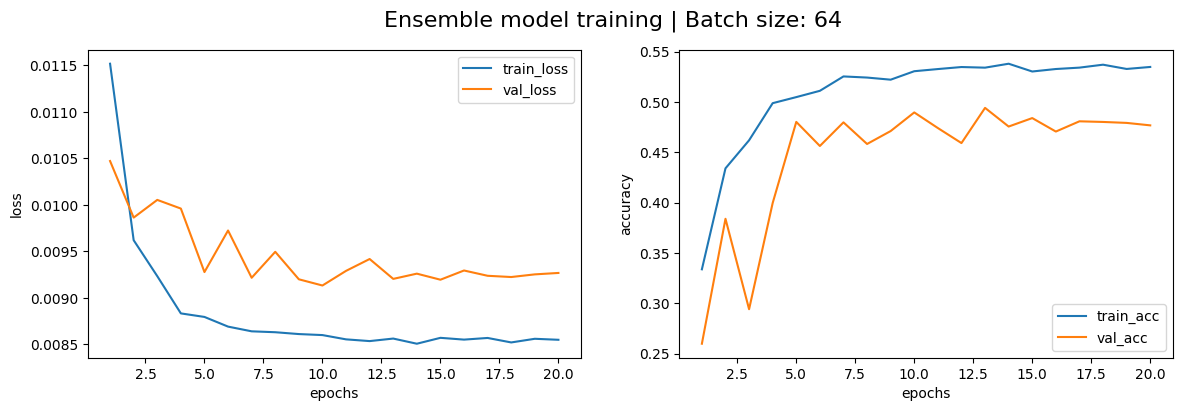


Training results:
	Min val loss 0.0091 was achieved during iteration #10
	Val accuracy during min val loss is 0.4896


In [24]:

ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=20,
                                     train_dataloader=train_loader_ws_all,
                                     val_dataloader=valid_loader_all)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=20,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [29]:

test_dataloader = DataLoader(testset_all, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_loader_all):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 151/151 [05:37<00:00,  2.24s/it]


IndexError: slice() cannot be applied to a 0-dim tensor.

In [34]:
target_list=[]
for samples, targets in test_dataloader:
    target_list.extend(targets)

get_metrics(all_preds, target_list)

Accuracy : tensor(0.4744)
F1-score :  tensor(0.4938)
Precision :  tensor(0.5772)
Recall :  tensor(0.4744)


(tensor(0.4744), tensor(0.4938), tensor(0.5772), tensor(0.4744))